In [12]:
%matplotlib notebook
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
from photutils import centroid_com
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
import sys
import os
import os.path
import cv2
from scipy.ndimage.morphology import binary_fill_holes

In [2]:
f = h5py.File("../CXI/cxi25410/res/iceFinderCampaign/output_r0144/type1/LCLS_2011_Feb28_r0144_163006_2feb_cspad.h5", 'r')
d = f['data/data'][:]
wavelength = f['LCLS/photon_wavelength_A'][0]/1e10
detector_distance = f['LCLS/detectorPosition'][0]/1000
pixel_size = 109.92*1e-6

In [3]:
def detect_peaks(img, int_threshold, peak_threshold, mask=None, center=None):
    threshold = int_threshold*(np.mean(img)+np.std(img))
    image_thresholded = np.copy(img)
    # TODO: look at only non-masked pixels
    image_thresholded[img<threshold] = 0
    #find the peak regions and label all the pixels
    labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded)
    peak_regions = scipy.ndimage.find_objects(labeled_image)
    peak_list = []
    for peak_region_i in peak_regions:
        ry = img[peak_region_i].shape[0]
        rx = img[peak_region_i].shape[1]
        if (ry>peak_threshold) and (rx>peak_threshold):
            img_peak = np.zeros_like(img)
            img_peak[peak_region_i] = img[peak_region_i]
            # TODO: improve peak width with 1D Gaussian fit
            if (ry > rx):
                r = ry/2. 
            else:
                r = rx/2.
                # current reference position is first element of 2D array (lower left corner), not center
                cy,cx = centroid_com(img_peak)
            #cy -= (img_peak.shape[0]-1)/2.
            #cx -= (img_peak.shape[1]-1)/2.
            peak_list.append([img[peak_region_i],(cy,cx),r])
    return peak_list

In [4]:
peak_center = []
for i in np.arange(len(detect_peaks(d, 2, 10))):
    peak_center.append(detect_peaks(d, 2, 10)[i][1])
for j in np.arange(len(peak_center)):
    # distance for the coordinate points (cx_i, cy_i) is sqrt((cx_{i+1} - cx_i)^2 + (cy_{i+1} - cy_i)^2 ) 
    cx_squared_last = (peak_center[j][0]-peak_center[j-1][0])**2
    cy_squared_last = (peak_center[j][1]-peak_center[j-1][1])**2
    last_peak_dist = np.sqrt(cx_squared_last+cy_squared_last)
    if j != np.arange(len(detect_peaks(d, 2, 10)))[-1]:
        cx_squared_next = (peak_center[j][0]-peak_center[j+1][0])**2
        cy_squared_next = (peak_center[j][1]-peak_center[j+1][1])**2
        next_peak_dist = np.sqrt(cx_squared_next+cy_squared_next)

In [5]:
# minimum distance between 2 points
import math
def nearestDistance(boundary, p):
    minDistList = map(lambda b: (b[0] - p[0])**2 + (b[1] - p[1])**2, boundary)
    minDist2 = min(minDistList)
    return math.sqrt(float(minDist2))

In [6]:
# method 2 thresholding the whole image and set everything below threshold equal to zero
## find peak regions based on the value of the threshold
image = d
center = None
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (image.shape[1]-1)/2
    yy = yy.astype(np.float64) - (image.shape[0]-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

threshold = 2*(np.mean(image)+np.std(image))
image_thresholded = np.copy(image)
image_thresholded[image<threshold] = 0
#find the peak regions and label all the pixels
labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded)
peak_regions = scipy.ndimage.find_objects(labeled_image)

In [7]:
# make a list of the bounding box of the peaks
peak_list = []
centroid_list = []
qx_list = []
qy_list = []
for peak_region_i in peak_regions:
    if d[peak_region_i].shape[0]>10 and d[peak_region_i].shape[1]>10:
        cx = np.sum(d[peak_region_i]*qx[peak_region_i])/np.sum(d[peak_region_i])
        cy = np.sum(d[peak_region_i]*qy[peak_region_i])/np.sum(d[peak_region_i])
        qx_list.append(qx[peak_region_i])
        qy_list.append(qy[peak_region_i])
        peak_list.append(d[peak_region_i])
        centroid_list.append((cx,cy))

In [8]:
index = 10
p = peak_list[index]
qx_index = qx_list[index]
qy_index = qy_list[index]
BG_level = 100 # needs to be optimized
p_sub = p - BG_level
peak_thresh = 2000 # needs to be optimized (roughly 10 photons above background)
p_mask = p_sub > peak_thresh
qx_cm =  np.sum(p[p_mask]*qx_index[p_mask])/np.sum(p[p_mask])
qy_cm =  np.sum(p[p_mask]*qy_index[p_mask])/np.sum(p[p_mask])
#qx_cm =  np.sum(p[p_mask]*qx[peak_regions[index]])/np.sum(p[p_mask])
#qy_cm = np.sum(p[p_mask]*qy[peak_regions[index]])/np.sum(p[p_mask])

In [9]:
q_total = np.sqrt(qx_index[p_mask]**2 + qy_index[p_mask]**2)/1e10

In [10]:
q_cm = []
for m,n in enumerate(peak_list):
    p = peak_list[m]
    qx_index = qx_list[m]
    qy_index = qy_list[m]
    BG_level = 100 # needs to be optimized
    p_sub = p - BG_level
    peak_thresh = 2000 # needs to be optimized (roughly 10 photons above background)
    p_mask = p_sub > peak_thresh
    q_cm.append((np.sum(p[p_mask]*qx_index[p_mask])/np.sum(p[p_mask])/1e10,np.sum(p[p_mask]*qy_index[p_mask])/np.sum(p[p_mask])/1e10))


In [14]:
a = distance.cdist(q_cm,q_cm)
min_dist = [np.min(ar[np.nonzero(ar)]) for ar in a]
all_dist = [ar[np.nonzero(ar)] for ar in a]
min_dist

[0.5698151006623239,
 0.5698151006623239,
 0.6171581239962163,
 0.06349025550866481,
 0.06349025550866481,
 0.6171581239962163,
 1.3953091175526433,
 0.10998960681288576,
 0.10463182600042263,
 0.10463182600042263,
 1.5483452132476894]

In [109]:
# calculate delta_z 
#theta = 0.5*np.arctan2(rad[index]*pixel_size, detector_distance)
#qz = qtot*np.sin(theta)
#np.sin(theta).max()

<IPython.core.display.Javascript object>


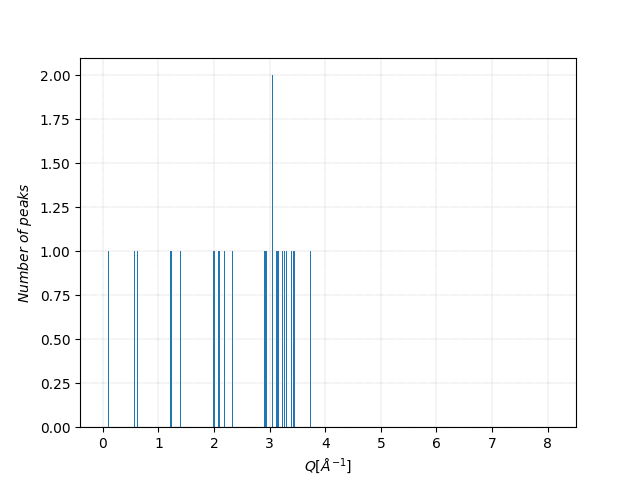

In [15]:
binwidth = 0.01
plt.figure()
distances = np.array(all_dist).flatten()
binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
yhist, bin_edges = np.histogram(distances, bins=binedges)
# ignore counting duplicated distances
yhist = yhist/2
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(yhist))])
plt.bar(bin_centers, yhist, width=binwidth)
#plt.plot(bin_centers, yhist/2, 'ko:')
plt.xlabel('$Q [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()